[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreofner/pyGPC/blob/master/demo.ipynb)

In [1]:
!git clone https://github.com/andreofner/pyGPC/

fatal: destination path 'pyGPC' already exists and is not an empty directory.


In [2]:
import pyGPC.MovingMNIST as MovingMNIST
from pyGPC.model import *

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Layer 0 cause state torch.Size([16, 256])
Layer 0 hidden state torch.Size([16, 256]) 

Layer 1 cause state torch.Size([16, 64])
Layer 1 hidden state torch.Size([16, 64]) 

Layer 2 cause state torch.Size([16, 32])
Layer 2 hidden state torch.Size([16, 32]) 

Layer 3 cause state torch.Size([16, 32])
Layer 3 hidden state torch.Size([16, 32]) 

SEQ 0 1.0357908407847087
SEQ 1 1.0364183982213337
SEQ 2 1.0346455574035645
SEQ 3 1.0372815529505413
SEQ 4 1.0380476315816243
SEQ 5 1.0371153354644775


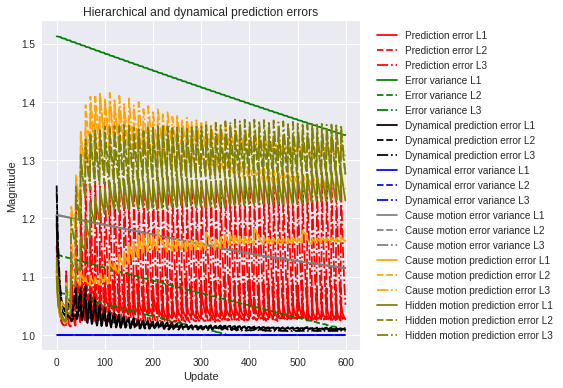

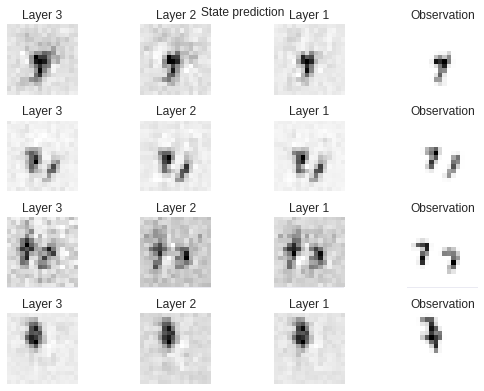

In [9]:
"""
Moving MNIST

Filtering with 3 hierarchical layers, each with 3 dynamical layers
"""

VIDEO = True
BATCH_SIZE, IMG_SIZE = 16, 16
LR_STATES, LR_WEIGHTS, LR_PRECISION, UPDATES = .01, 0.001, 0.0001, 10

train_set = MovingMNIST(root='.data/mnist', train=True, download=True,
                        transform=transforms.Compose([transforms.Scale(IMG_SIZE), transforms.ToTensor(), ]))
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)

# hierarchical net with three layers
cause_sizes = [IMG_SIZE * IMG_SIZE, 64, 32, 32]
hidden_sizes = [IMG_SIZE * IMG_SIZE, 64, 32, 32]
net = GPC_net(b_size=BATCH_SIZE, dynamical_net=False,
              cause_sizes=cause_sizes, hidden_sizes=hidden_sizes)
net.print_states()

# the state motion of each hierarchical layer is predicted by a dynamical network
net_d1 = GPC_net(b_size=BATCH_SIZE, dynamical_net=True, obs_layer=net.layers[0],
                cause_sizes=[cause_sizes[1]//(l+1) for l in range(4)],
                hidden_sizes=[hidden_sizes[1]//(l+1) for l in range(4)])
net_d2 = GPC_net(b_size=BATCH_SIZE, dynamical_net=True, obs_layer=net.layers[1],
                cause_sizes=[cause_sizes[2]//(l+1) for l in range(4)],
                hidden_sizes=[hidden_sizes[2]//(l+1) for l in range(4)])
net_d3 = GPC_net(b_size=BATCH_SIZE, dynamical_net=True, obs_layer=net.layers[2],
                cause_sizes=[cause_sizes[3]//(l+1) for l in range(4)],
                hidden_sizes=[hidden_sizes[3]//(l+1) for l in range(4)])

# logging
errors, cov_h, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3 = [[] for _ in range(8)]
err_g1, err_g2, err_g3, cov_g1, cov_g2, cov_g3 = [[] for _ in range(6)]
err_h1, err_h2, err_h3 = [], [], []
vid_in, vid_p1, vid_p2, vid_p3 = [], [], [], []

for seq_id, (seq, _) in enumerate(train_loader):
    seq = torch.transpose(seq, 0,1)
    for id, data in enumerate(seq):
        data = data.reshape([-1,IMG_SIZE*IMG_SIZE]).float()

        # step hierarchical net
        e, _, _, ch, _ = net.iterative_inference(data, updates=UPDATES)

        # step dynamical nets  # todo return covariance of hidden state change prediction error
        eg1, eh1, ed1, cg1, cd1 = net_d1.iterative_inference(updates=UPDATES)
        eg2, eh2, ed2, cg2, cd2 = net_d2.iterative_inference(updates=UPDATES)
        eg3, eh3, ed3, cg3, cd3 = net_d3.iterative_inference(updates=UPDATES)

        # logging # todo sumamrize across layers
        errors, cov_h = errors + e, cov_h + ch
        errors_d1, cov_d1 = errors_d1 + ed1, cov_d1 + cd1
        errors_d2, cov_d2 = errors_d2 + ed2, cov_d2 + cd2
        errors_d3, cov_d3 = errors_d3 + ed3, cov_d3 + cd3
        err_g1, cov_g1 = err_g1 + eg1, cov_g1 + cg1
        err_g2, cov_g2 = err_g2 + eg2, cov_g2 + cg2
        err_g3, cov_g3 = err_g3 + eg3, cov_g3 + cg3

        err_h1 = err_h1+eh1; err_h2 = err_h2+eh2; err_h3 = err_h3+eh3;

        # track state motion
        [n.transition() for n in [net, net_d1, net_d2, net_d3]]

        # create video
        if VIDEO:
            input, preds = plot_2D(net=net, img_size=IMG_SIZE, plot=False)
            vid_in.append(input.detach().numpy().reshape([IMG_SIZE, IMG_SIZE]))
            vid_p1.append(preds[0][0].reshape([IMG_SIZE, IMG_SIZE]))
            vid_p2.append(preds[1][0].reshape([IMG_SIZE, IMG_SIZE]))
            vid_p3.append(preds[2][0].reshape([IMG_SIZE, IMG_SIZE]))

        if id == 0: print(f"SEQ {seq_id}", np.asarray(errors)[-1].mean())
    if seq_id == 5: break

# Overview plots

plot_graph(errors, errors_d1, errors_d2, errors_d3, cov_d1, cov_d2, cov_d3,cov_g1,
           cov_g2, cov_g3, err_g1, err_g2, err_g3, err_h1, err_h2, err_h3, cov_h,
           hierarchical=True, g_coords=True, dynamical=True)
input, preds = plot_2D(net=net, img_size=IMG_SIZE, title="State prediction", examples=4, plot=True)

# Create video
if VIDEO:
    for data, name in zip([vid_in, vid_p1], ["input","predl1"]):
        images = np.asarray([v*100 for v in data])
        images *= (255.0 / images.max())
        imgs = [Image.fromarray(img) for img in images]
        imgs[0].save(f"./{name}.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [10]:
import IPython
display(IPython.display.Image(open('./input.gif','rb').read()))
display(IPython.display.Image(open('./predl1.gif','rb').read()))